**Modeling Analysis for Canalyst**

*Sample Notebook*

10/10/2021

Maintainer: jed.gore@canalyst.com

<span style='color:#00838F'>**This notebook is intended as an example of a workflow highlighting the use of candas_datareader**</span>

Please request an api key at:
https://app.canalyst.com/settings/api-tokens

In [1]:

import sys
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', 400)

import canalyst_candas.candas as cd
import canalyst_candas.candas_datareader as cdr
from canalyst_candas.configuration.config import Config

config_info = {
  "canalyst_api_key": "",
  "s3_access_key_id": "",
  "s3_secret_key": "",
  "fred_key": "",
  "default_dir": "",
  "mds_host": "",
  "wp_host": ""
}

config = Config(config=config_info)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


<b>Key Parameters</b>

Establish our price ticker (data source yahoo finance) and our Canalyst ticker (we use Bloomberg ticker format)

In [2]:
ticker = "AAL US"
yahoo_ticker = "AAL" #need this for prices
index_ticker = "^GSPC" #this is our benchmark index (^GSPC for S&P 500, EFA for msci eafa etc)
alpha_days = "alpha_1_day" #or alpha_5_day or alpha_10_day
regression_window = 12
model_set = cd.ModelSet(ticker_list=[ticker], config=config)

Get list of tickers available to you on our server

In [3]:
#instantiate a search object, which we will also use later
search = cd.Search(config)
search.get_ticker_list(ticker="").head()

,File,Bloomberg Ticker,Thomson Ticker
0,10x Genomics TXG US,TXG US,TXG.OQ
1,1-800-FLOWERS.COM FLWS US,FLWS US,FLWS.OQ
2,1Life Healthcare ONEM US,ONEM US,ONEM.OQ
3,1stDibs DIBS US,DIBS US,DIBS.OQ
4,23andMe ME US,VGAC US,VGAC.N


Or just check for one ticker

In [4]:
search.get_ticker_list(ticker = ticker)

,File,Bloomberg Ticker,Thomson Ticker
134,American Airlines AAL US,AAL US,AAL.OQ


Let's take a look at the list of available segments (categories) in the model.

In [5]:
categories = list(model_set.model_frame(ticker=ticker,
                      period_duration_type = "fiscal_quarter", 
                      mrq=True)['category'].unique())
categories

['Growth Analysis',
 'Operating Stats - Traffic and Cost Summary (PR, 10-Q/K)',
 'Segmented Results - Revenue Breakdown by Type (PR, 10-Q/K)',
 'Segmented Results - Traffic Analysis by Geography (PR, 10-Q/K)',
 'Segmented Results - Passenger Mile Yield, PRASM and RASM by Geography (PR, 10-Q/K)',
 'Segmented Results - Cargo Price/Volume Analysis (PR)',
 'Key Metrics - Loyalty Program Mileage Credits (10-Q/K)',
 'Segmented Results - OPEX Breakdown (PR)',
 'Operating Statistics - Salaries, Wages and Benefits  (PR)',
 'Operating Statistics - Aircraft Fuel and Related Taxes (PR)',
 'Operating Statistics - Maintenance, Materials and Repairs (PR)',
 'Operating Statistics - Other Rent and Landing Fees (PR)',
 'Operating Statistics - Aircraft Rent (PR)',
 'Operating Statistics - Selling Expenses (PR)',
 'Operating Statistics - Depreciation and Amortization (PR)',
 'Operating Statistics - Special Items (PR)',
 'Operating Statistics - Other OPEX (PR)',
 'Operating Statistics - Regional Capacity P

Goal: Create a pivoted view of one category of the model_frame

In [6]:
model_set.models[ticker].mrq()

,period_name,period_end_date
0,Q3-2021,2021-09-30


In [7]:
model_set.model_frame(ticker=ticker,
                      category=categories[0], #filter to one or more category
                      period_duration_type = "fiscal_quarter", #only fiscal quarters
                      is_historical=True, #historical data only
                      pivot=True, #pivot the data so dates are on column headers
                     n_periods=regression_window).head()

period_name_sorted,ticker,name_index,category,time_series_name,time_series_description,is_driver,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3
0,AAL US,7,Growth Analysis,z_DYKK2Y0171_MO_OS_mainlinepassengerrevenueyoygrowth,"Domestic passenger revenue growth, %",False,3.78,3.78,4.22,5.25,4.41,-20.01,-87.18,-70.62,-66.01,-54.07,430.09,185.15
1,AAL US,8,Growth Analysis,z_DYKK2Y0171_MO_GA_LatinAmericapassengerRevenuegrowth,"Latin America passenger revenue growth, %",False,-2.55,-5.12,-3.35,0.66,2.61,-13.93,-97.26,-85.88,-61.71,-59.15,2652.94,456.40
2,AAL US,9,Growth Analysis,z_DYKK2Y0171_MO_GA_AtlanticpassengerRevenuegrowth,"Atlantic passenger revenue growth, %",False,5.36,0.60,8.40,6.12,4.75,-22.29,-97.01,-96.49,-96.52,-95.79,197.62,628.57
3,AAL US,10,Growth Analysis,z_DYKK2Y0171_MO_OS_regionalpassengerrevenueyoygrowth,"Pacific passenger revenue growth, %",False,-3.15,-3.72,-13.02,-13.24,-5.42,-48.97,-98.59,-95.64,-91.98,-89.90,700.00,181.25
4,AAL US,11,Growth Analysis,MO_GA_REV_Passenger,"Total passenger revenue growth, %",False,2.85,1.88,3.16,4.11,3.87,-20.47,-89.94,-76.90,-69.18,-58.61,490.70,213.27


Next we set up a dataset which includes:
- a full modelframe of quarterly data 
- a set of earnings data, 
- rolling 252 day beta vs the S&P 500
- 1 and 5 and 10 day alpha (excess beta adjusted performance vs the S&P 500)

In [8]:
df_data = model_set.pe_dataset(ticker,yahoo_ticker,index_ticker)

In a separate example, we can:
    <br>- pull just the earnings and prices dataframe for this ticker 
    <br>- chart earnings surprise vs stock movement

In [9]:
df = cdr.get_earnings_and_prices(yahoo_ticker,index_ticker = index_ticker) 

In [10]:
df.tail()

,ticker,earnings_date,companyshortname,price_date,epsestimate,epsactual,epssurprisepct,alpha_1_day,alpha_5_day,alpha_10_day,beta_252,plus_1_return,plus_5_return,plus_10_return,mktclose_plus_1_return,mktclose_plus_5_return,mktclose_plus_10_return
46,AAL,2020-07-23,American Airlines Group Inc.,2020-07-23,-7.70,-7.82,-1.51,-0.02,-0.05,0.06,1.37,-0.03,-0.05,0.11,-0.01,0.00,0.04
47,AAL,2021-01-28,American Airlines Group Inc.,2021-01-28,-4.11,-3.86,6.17,-0.03,-0.07,-0.11,1.30,-0.05,-0.04,-0.06,-0.02,0.02,0.03
48,AAL,2021-04-22,American Airlines Group Inc.,2021-04-22,-4.30,-4.32,-0.35,0.03,0.03,0.04,1.69,0.05,0.06,0.07,0.01,0.02,0.02
49,AAL,2021-07-22,American Airlines Group Inc.,2021-07-22,-1.96,-1.69,13.82,-0.01,-0.01,-0.03,1.00,0.00,0.00,-0.01,0.01,0.01,0.01
50,AAL,2021-10-21,American Airlines Group Inc.,2021-10-21,-1.04,-0.99,4.72,-0.04,-0.05,0.00,1.14,-0.04,-0.04,0.04,-0.00,0.01,0.03


We can use pandas' describe() function to get the mean eps surprise and subsequent stock movement for this stock.

In [11]:
df.describe().reset_index() #row 2 is the mean of the full series of data

,index,epsestimate,epsactual,epssurprisepct,alpha_1_day,alpha_5_day,alpha_10_day,beta_252,plus_1_return,plus_5_return,plus_10_return,mktclose_plus_1_return,mktclose_plus_5_return,mktclose_plus_10_return
0,count,51.00,51.00,51.00,47.00,47.00,47.00,47.00,51.00,51.00,51.00,51.00,51.00,51.00
1,mean,0.05,0.11,17.71,-0.01,-0.01,-0.01,1.44,-0.01,-0.01,-0.00,0.00,0.00,0.00
2,std,1.90,1.90,113.98,0.03,0.07,0.09,0.33,0.03,0.08,0.12,0.01,0.02,0.03
3,min,-7.70,-7.82,-254.61,-0.08,-0.21,-0.21,0.86,-0.11,-0.21,-0.27,-0.03,-0.04,-0.09
4,25%,-0.98,-0.89,0.79,-0.02,-0.05,-0.06,1.17,-0.03,-0.05,-0.06,-0.01,-0.01,-0.01
5,50%,0.51,0.54,2.56,-0.01,-0.01,0.00,1.45,-0.00,-0.01,-0.01,0.00,0.00,0.01
6,75%,1.40,1.42,7.72,0.02,0.03,0.05,1.64,0.02,0.05,0.06,0.01,0.01,0.02
7,max,2.72,2.77,758.82,0.04,0.11,0.20,2.18,0.07,0.18,0.44,0.02,0.04,0.05


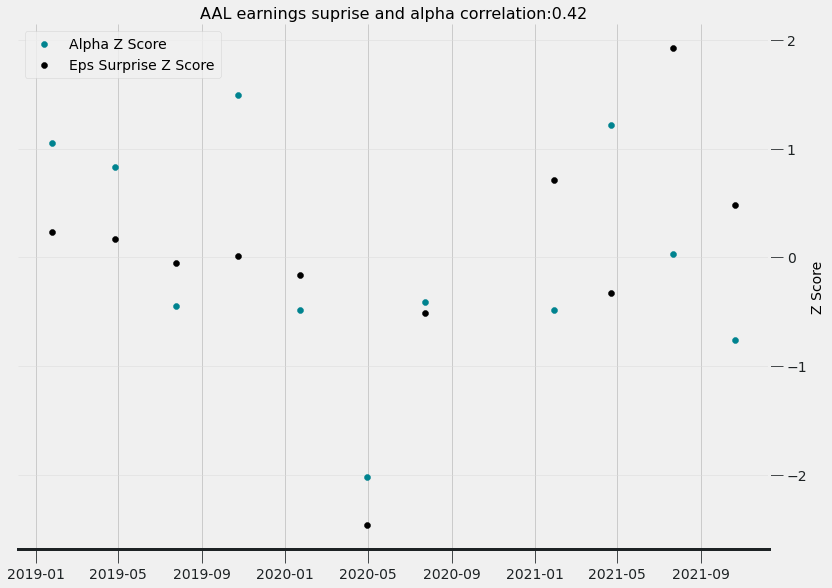

In [12]:
cdr.plot_eps_surprise_data(df[df['earnings_date']>'2019-01-01'],alpha_days) 

#this calculates a z-score for eps surprise and stock movement.  
#z score = (value - mean(value)) / stdev(value) scales everything by standard deviation for comparison purposes

The chart shows the earnings correlation, but we can also look at a regression result to get the same answer.

In [13]:
cdr.regress_dataframe(df,
                       y_col=alpha_days,
                       x_col='epssurprisepct',
                       y_filter="",
                      z_score = True,
                      n=regression_window)

C:\Users\JedGore\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            alpha_1_day   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.803
Date:                Wed, 17 Nov 2021   Prob (F-statistic):              0.209
Time:                        16:07:44   Log-Likelihood:                -18.989
No. Observations:                  12   AIC:                             41.98
Df Residuals:                      10   BIC:                             42.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.3270      1.061      1.251      0.239      -1.037       3.691
epssurprisepct     9.3442      6.959      1.343      0.209      -6.162      24.850
==============================================================================
Omnibus:                        5.169   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                1.424
Skew:                           0.282   Prob(JB):                        0.491
Kurtosis:                       1.409   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<B>EPS beats and misses aren't a key driver of stock price.  This begs the question: what is? </b><br>
Again, let's review the model categories:

Let's filter down to just a few categories, rather than all of them.

And let's regress EVERY time series name against n day alpha, over n regression periods (both specified above), and rank by r-squared.

In [14]:

like_list = ['Stats','Analysis','Metrics','Segmented Results']
category_filter = []
for category in categories:
    for like in like_list:
        if like in category:
            category_filter.append(category)
            
category_filter = list(set(category_filter))
category_filter


['Segmented Results - Traffic Analysis by Geography (PR, 10-Q/K)',
 'Segmented Results - Regional Expenses Breakdown (10-Q/K)',
 'Segmented Results - Cargo Price/Volume Analysis (PR)',
 'Segmented Results - Total Revenue Breakdown by Type (10-Q/K)',
 'Key Metrics - Aircrafts (PR, 10-Q/K)',
 'Key Metrics - Employees (PR, 10-Q/K)',
 'Segmented Results - Revenue Breakdown by Type (PR, 10-Q/K)',
 'Segmented Results - Mainline vs Regional Data Split (PR)',
 'Key Metrics - Passengers (PR, 10-Q/K)',
 'Key Metrics - Loyalty Program Mileage Credits (10-Q/K)',
 'Margin Analysis',
 'Key Metrics - Fleet Statistics (10-Q/K)',
 'Operating Stats - Traffic and Cost Summary (PR, 10-Q/K)',
 'Key Metrics - Unit Economics (PR, 10-Q/K)',
 'Segmented Results - Passenger Mile Yield, PRASM and RASM by Geography (PR, 10-Q/K)',
 'Growth Analysis',
 'Segmented Results - OPEX Breakdown (PR)']

In [15]:
df_data.tail()

,period_name,period_duration_type,period_start_date,period_end_date,category,time_series_name,category_type_name,time_series_description,unit_description,unit_symbol,...,name_index,period_name_sorted,earnings_date_q,price_ticker,ticker,earnings_date,beta_252,alpha_1_day,alpha_5_day,alpha_10_day
18979,Q3-2021,fiscal_quarter,2021-07-01,2021-09-30,Balance Sheet,MO_BS_OCI,Financials As Reported,Accumulated other comprehensive loss,USD,$,...,963,2021Q3,2021Q4,AAL,AAL US,2021-10-21,1.14,-0.04,-0.05,0.00
18980,Q3-2021,fiscal_quarter,2021-07-01,2021-09-30,Balance Sheet,MO_BS_RetainedEarnings,Financials As Reported,Retained earnings (deficit),USD,$,...,964,2021Q3,2021Q4,AAL,AAL US,2021-10-21,1.14,-0.04,-0.05,0.00
18981,Q3-2021,fiscal_quarter,2021-07-01,2021-09-30,Balance Sheet,MO_BS_SE,Financials As Reported,Total SE,USD,$,...,965,2021Q3,2021Q4,AAL,AAL US,2021-10-21,1.14,-0.04,-0.05,0.00
18982,Q3-2021,fiscal_quarter,2021-07-01,2021-09-30,Balance Sheet,MO_BS_NCI,Financials As Reported,NCI,USD,$,...,966,2021Q3,2021Q4,AAL,AAL US,2021-10-21,1.14,-0.04,-0.05,0.00
18983,Q3-2021,fiscal_quarter,2021-07-01,2021-09-30,Balance Sheet,MO_BS_TLSE,Financials As Reported,Total Liabilities & SE,USD,$,...,967,2021Q3,2021Q4,AAL,AAL US,2021-10-21,1.14,-0.04,-0.05,0.00


In [16]:
df_kpi = cdr.regress_dataframe_time_series_groups(df_data = df_data,
                                         y_name=alpha_days,
                                         return_grouped=True,
                                         category = category_filter,
                                         n_periods=regression_window)
df_kpi[['ticker','time_series_description','category','rsquared']].head(20)

,ticker,time_series_description,category,rsquared
150,AAL US,"EBITDAR per passenger growth, %","Key Metrics - Passengers (PR, 10-Q/K)",0.66
98,AAL US,"CTMs, mm mi",Segmented Results - Cargo Price/Volume Analysis (PR),0.63
20,AAL US,"CTMs, mm mi","Operating Stats - Traffic and Cost Summary (PR, 10-Q/K)",0.63
151,AAL US,"EBIT per passenger growth, %","Key Metrics - Passengers (PR, 10-Q/K)",0.59
155,AAL US,"EBITDAR per passenger, $/passenger","Key Metrics - Passengers (PR, 10-Q/K)",0.49
156,AAL US,"EBIT per passenger, $/passenger","Key Metrics - Passengers (PR, 10-Q/K)",0.49
63,AAL US,"Domestic ASMs mix, %","Segmented Results - Traffic Analysis by Geography (PR, 10-Q/K)",0.49
160,AAL US,"EBITDAR per aircraft growth, %","Key Metrics - Aircrafts (PR, 10-Q/K)",0.48
130,AAL US,"Total OPEX per RPM, cents/RPM",Segmented Results - OPEX Breakdown (PR),0.48
170,AAL US,"EBITDAR per employee growth, %","Key Metrics - Employees (PR, 10-Q/K)",0.48


In [17]:

from IPython.display import Markdown as md
md(f"{df_kpi.iloc[0]['time_series_name']}, with the highest rsquared and highest beta (intercept), is the key KPI for this stock. <br>The formula for 10 day post-earnings alpha for this metric is:<br> {round(float(df_kpi.iloc[0]['intercept']),2)} + .{round(float(df_kpi.iloc[0]['slope']),3)} * ({df_kpi.iloc[0]['time_series_name']})")

z_DYKK2Y0171_MO_OS_EBITDARperpassengergrowth, with the highest rsquared and highest beta (intercept), is the key KPI for this stock. <br>The formula for 10 day post-earnings alpha for this metric is:<br> -126.36 + .4423.539 * (z_DYKK2Y0171_MO_OS_EBITDARperpassengergrowth)

We can see the history of the R-squared in a dataframe (plot=False) to check for regime changes, also the final rsquared should equal what we see above. <br>
Feel free to override top_kpi with another kpi of your choice.

In [18]:

top_kpi = df_kpi.iloc[0]['time_series_name']
print(top_kpi)
#top_kpi = ''
cdr.rolling_r_squared(df_data,
                      top_kpi,
                      y_name=alpha_days,
                      window=regression_window,
                      plot=False).tail()

z_DYKK2Y0171_MO_OS_EBITDARperpassengergrowth


,period_name,earnings_date,alpha_1_day,value,slope,rsquared,intercept
15367,Q3-2020,2020-07-23,-0.02,-398.66,4027.67,0.51,-83.27
16158,Q4-2020,2021-01-28,-0.03,-320.45,4785.97,0.65,-108.97
16949,Q1-2021,2021-04-22,0.03,-54.97,4830.05,0.73,-134.20
17740,Q2-2021,2021-07-22,-0.01,-116.45,4809.68,0.71,-129.47
18531,Q3-2021,2021-10-21,-0.04,-132.16,4423.54,0.66,-126.36


We can see the history of the R-Squared for the top KPI to check for "regime" changes

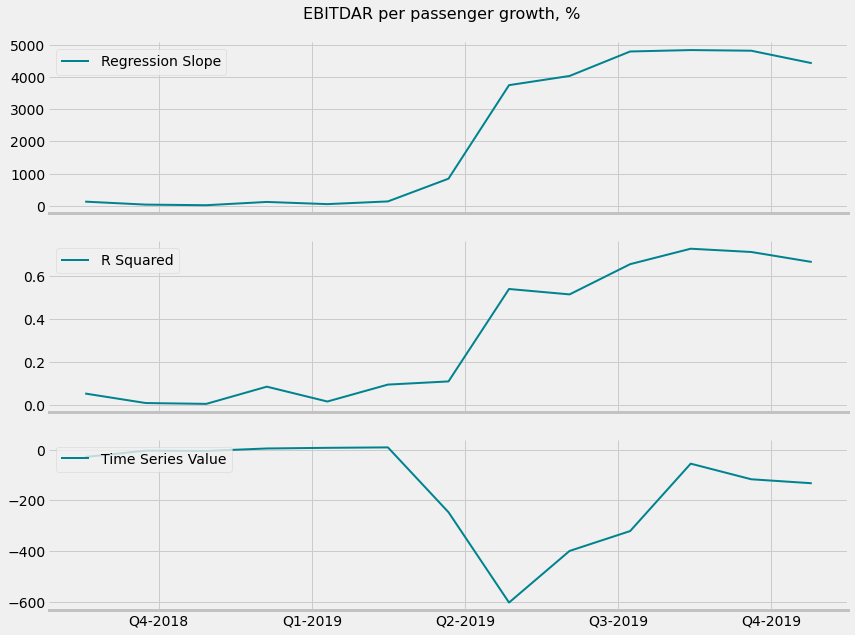

In [19]:
cdr.rolling_r_squared(df_data,
                      top_kpi,
                      window=regression_window,
                       y_name=alpha_days,
                      plot=True)

We can see the price / time series history of the top KPI to check whether it makes sense

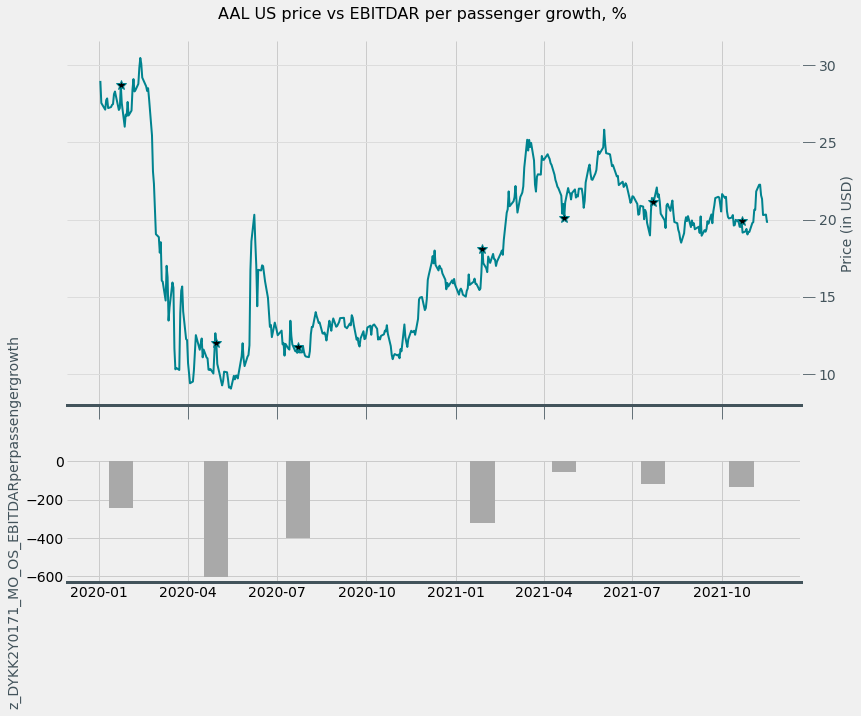

In [20]:
time_series_name=top_kpi
df_prices = cdr.get_price_data(yahoo_ticker, reset=True, rolling_betas=False, index_ticker=index_ticker)
cdr.plot_prices_against_time_series(df_data,df_prices,time_series_name,"value") #raw value

In a separate analysis, we can pull the key drivers off the precedent tree for revenue, and rank order their impact on revenue.

In [51]:
#launch a node tree for visual review
model_set.create_model_map(ticker=ticker,time_series_name="MO_RIS_REV",col_for_labels = "time_series_description").show() #launches in a separate browser window

https://mds.canalyst.com/api/equity-model-series/DYKK2Y0171/equity-models/Q3-2021.23/time-series/MO_RIS_REV/forecast-data-points/Q4-2021/drivers/?format=dot


In [22]:

#use the same node tree to extract key drivers (red nodes)
df = model_set.models[ticker].key_driver_map("MO_RIS_REV")
return_series = 'MO_RIS_REV'
driver_list_df = []
for i, row in df.iterrows():

    time_series_name = row['time_series_name']
    print(f"scenario: move {time_series_name} 1% and get resultant change in {return_series}")

    #create a param dataframe for each time series name in our list
    df_1_param = model_set.forecast_frame(time_series_name,
                         n_periods=-1,
                         function_name='multiply',
                         function_value=1.01)


    d_output=model_set.fit(df_1_param,return_series) #our fit function will return a link to scenario engine JSON for audit

    df_output = model_set.filter_summary(d_output,period_type='Q')

    df_merge = pd.merge(df_output,df_1_param,how='inner',left_on=['ticker','period_name'],right_on=['ticker','period_name'])

    driver_list_df.append(df_merge) #append to a list for concatenating at the end
df = pd.concat(driver_list_df).sort_values('diff',ascending=False)[['ticker','time_series_name_y','diff']]
df = df.rename(columns={'time_series_name_y':'time_series_name'})
df['diff'] = df['diff']-1
df = df.sort_values('diff')
df.plot(x='time_series_name',y='diff',kind='barh',title=ticker+" Key Drivers Revenue Sensitivity")

https://mds.canalyst.com/api/equity-model-series/DYKK2Y0171/equity-models/Q3-2021.23/time-series/MO_RIS_REV/forecast-data-points/Q4-2021/drivers/?format=dot
scenario: move z_DYKK2Y0171_MO_OS_OtherrevenueGrowth 1% and get resultant change in MO_RIS_REV
AAL US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/DYKK2Y0171/equity-models/Q3-2021.23/scenarios/ArMcRe1zUlWy5Im-E4v7YA/
scenario: move MO_OS_ASM_Domestic_Growth 1% and get resultant change in MO_RIS_REV
AAL US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/DYKK2Y0171/equity-models/Q3-2021.23/scenarios/k5nEY4ULVOmA-_z6kKUhRw/
scenario: move MO_OS_ASM_LatinAmerica_Growth 1% and get resultant change in MO_RIS_REV
AAL US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/DYKK2Y0171/equity-models/Q3-2021.23/scenarios/TGuQTlYaV_q03Iy2M_hzcw/
scenario: move MO_OS_ASM_Atlantic_Growth 1% and get resultant change in MO_RIS_REV
AAL US scenario_id_url: https://mds.canalyst.com/api/equity-model-

Now let's rank order the revenue sensitivity

<AxesSubplot:title={'center':'AAL US Key Drivers Revenue Sensitivity'}, ylabel='time_series_name'>

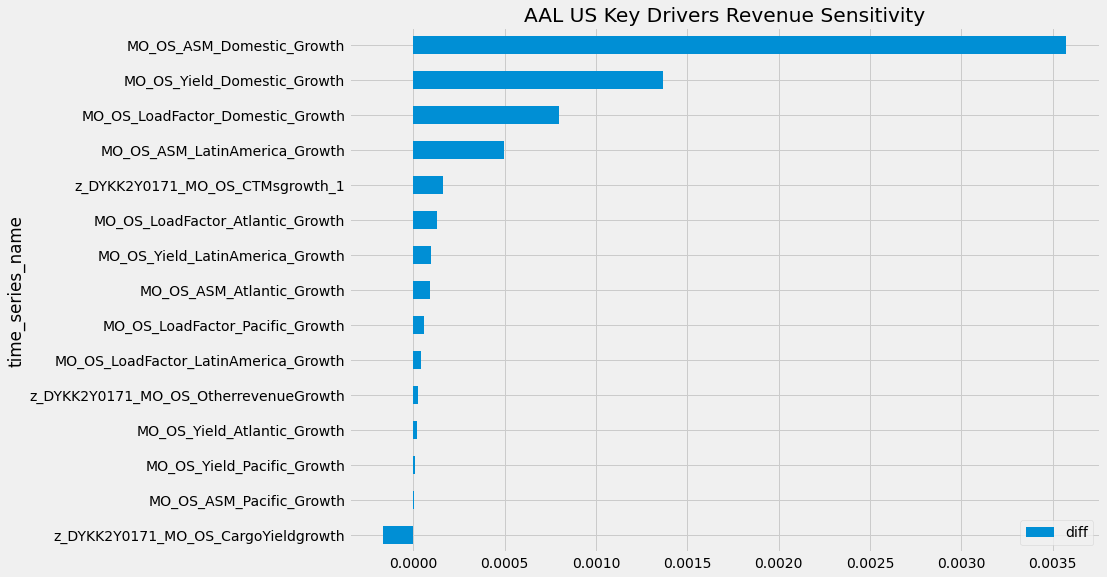

In [49]:
df = pd.concat(driver_list_df).sort_values('diff',ascending=False)[['ticker','time_series_name_y','diff']]
df = df.rename(columns={'time_series_name_y':'time_series_name'})
df['diff'] = df['diff']-1
df = df.sort_values('diff')
df.plot(x='time_series_name',y='diff',kind='barh',title=ticker+" Key Drivers Revenue Sensitivity")

You can check this dataframe vs the regression dataframe above to see overlap

In [24]:
pd.merge(df_kpi,pd.concat(driver_list_df),how='inner',left_on=['ticker','time_series_name'],right_on=['ticker','time_series_name_y'])[['ticker','name_index','time_series_name','time_series_description_x','diff','rsquared','slope','intercept']]

,ticker,name_index,time_series_name,time_series_description_x,diff,rsquared,slope,intercept
0,AAL US,123,MO_OS_Yield_LatinAmerica_Growth,"Latin America passenger mile yield growth, %",1.00010,0.27783,-108.52315,-3.37159
1,AAL US,124,MO_OS_Yield_Atlantic_Growth,"Atlantic passenger mile yield growth, %",1.00002,0.25040,-312.13559,-4.63829
2,AAL US,155,z_DYKK2Y0171_MO_OS_CargoYieldgrowth,"Cargo Yield growth, %",0.99983,0.19839,-562.73983,25.27328
3,AAL US,125,MO_OS_Yield_Pacific_Growth,"Pacific passenger mile yield growth, %",1.00001,0.16015,-274.48548,15.75940
4,AAL US,105,MO_OS_LoadFactor_Domestic_Growth,"Domestic Load Factor change, bps",1.00080,0.15432,228.01900,-1.34026
5,AAL US,106,MO_OS_LoadFactor_LatinAmerica_Growth,"Latin America Load Factor change, bps",1.00004,0.14435,263.20938,-3.66657
6,AAL US,107,MO_OS_LoadFactor_Atlantic_Growth,"Atlantic Load Factor change, bps",1.00013,0.10751,301.54159,-13.81492
7,AAL US,108,MO_OS_LoadFactor_Pacific_Growth,"Pacific Load Factor change, bps",1.00006,0.10114,280.22222,-16.83381
8,AAL US,122,MO_OS_Yield_Domestic_Growth,"Domestic passenger mile yield growth, %",1.00137,0.04154,79.18352,-5.24371
9,AAL US,156,z_DYKK2Y0171_MO_OS_CTMsgrowth_1,"CTMs growth, %",1.00017,0.02768,334.81895,6.29598


We can look at the MOST impactful revenue driver on a price / volume chart

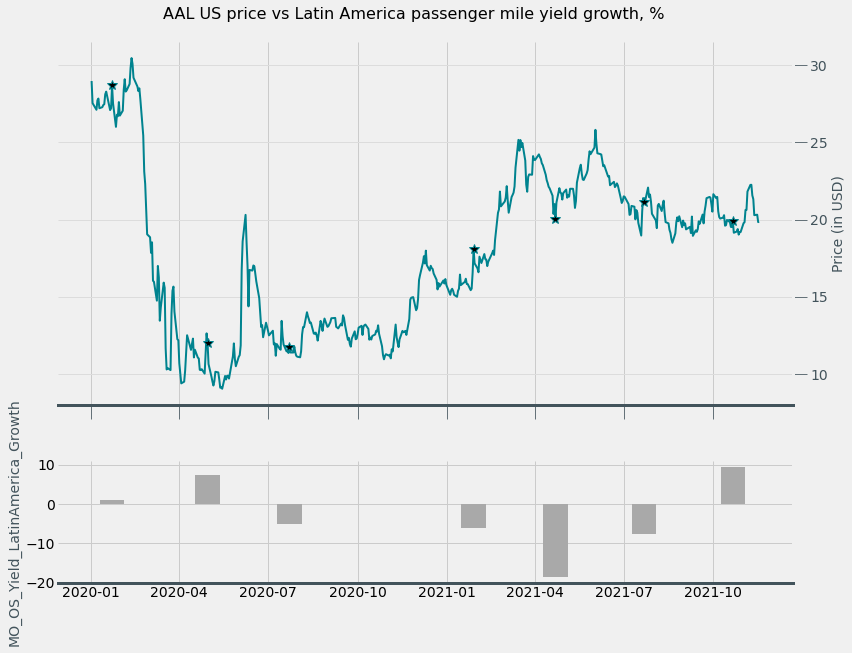

In [25]:
#top_kpi = pd.concat(driver_list_df).sort_values('diff',ascending=False).iloc[0]['time_series_name_y']
search_kpi = pd.merge(df_kpi,pd.concat(driver_list_df),how='inner',left_on=['ticker','time_series_name'],right_on=['ticker','time_series_name_y']).iloc[0]['time_series_name']
time_series_name=search_kpi
cdr.plot_prices_against_time_series(df_data,df_prices,time_series_name,"value") #raw value

Lastly, we can see what other companies may also have a time series like this which we can use for follow-on trade ideas.

In [26]:
search_kpi = pd.merge(df_kpi,pd.concat(driver_list_df),how='inner',left_on=['ticker','time_series_name'],right_on=['ticker','time_series_name_y']).iloc[0]['time_series_description_x']
print(search_kpi)

Latin America passenger mile yield growth, %


In [27]:
search_kpi = search.remove_stopwords(search_kpi) #clean up the kpi for just the root idea
print(search_kpi)

Latin America passenger mile yield growth


The search is sorted by number of word matches

In [28]:

df = search.search_time_series(ticker = "",
                 sector="",
                 category="",
                 unit_type="",
                 time_series_description=search_kpi).head(15)

df[df['ticker']!=ticker]


Building search index...
Done


,ticker,CSIN,Path,Filename,category,time_series_description,time_series_name,period_duration_type,unit_type,is_driver,value,search_matches
228593,UAL US,K25QNC0129,US Companies/Industrials/Transportation/Airlines,United Airlines Holdings UAL US.xlsx,"Segmented Results - Passenger Mile Yield, PRASM and RASM by Geography (PR, 10-Q/K)","Latin America passenger mile yield growth, %",MO_OS_Yield_LatinAmerica_Growth,fiscal_quarter,percentage,True,-2.02732,6
83068,DAL US,2EFOXB0147,US Companies/Industrials/Transportation/Airlines,Delta Airlines DAL US.xlsx,"Segmented Results - Latin America (PR, 10-Q/K)","Latin America passenger mile yield growth, %",MO_OS_Yield_LatinAmerica_Growth,fiscal_quarter,percentage,True,2.06186,6
228599,UAL US,K25QNC0129,US Companies/Industrials/Transportation/Airlines,United Airlines Holdings UAL US.xlsx,"Segmented Results - Passenger Mile Yield, PRASM and RASM by Geography (PR, 10-Q/K)","Latin America passenger mile yield, cents/RPM",MO_OS_Yield_LatinAmerica,fiscal_quarter,ratio,False,0.14226,5
495214,TRI US,0FOS6S0142,Canadian Companies/Financials/Brokers and Capital Markets,Thomson Reuters TRI CN TRI US.xlsx,Segmented Results - Geographic Breakdown (MD&A),"Americas (North America, Latin America and South America) revenues, mm",z_0FOS6S0142_MO_OS_AmericasNorthAmericaLatinAmericaandSouthAmericarevenues,fiscal_quarter,currency,False,0.00000,5
82984,DAL US,2EFOXB0147,US Companies/Industrials/Transportation/Airlines,Delta Airlines DAL US.xlsx,"Operating Stats - Traffic and Cost Summary (PR, 10-Q/K)","Latin America passenger mile yield, cents/RPM",MO_OS_Yield_LatinAmerica,fiscal_quarter,ratio,False,0.14317,5
83073,DAL US,2EFOXB0147,US Companies/Industrials/Transportation/Airlines,Delta Airlines DAL US.xlsx,"Segmented Results - Latin America (PR, 10-Q/K)","Latin America passenger mile yield, cents/RPM",z_2EFOXB0147_MO_OS_LatinAmericapassengermileyield_1,fiscal_quarter,ratio,False,0.14317,5
703414,ULCC US,OD47MC0123,US Companies/Industrials/Transportation/Airlines,Frontier Airlines ULCC US.xlsx,Growth Analysis,"Passenger mile yield growth, %",MO_GA_Yield,fiscal_quarter,percentage,False,-56.04930,4
703457,ULCC US,OD47MC0123,US Companies/Industrials/Transportation/Airlines,Frontier Airlines ULCC US.xlsx,Segmented Results - Traffic Analysis (FS),"Passenger mile yield growth, %",z_OD47MC0123_MO_OS_yieldgrowth,fiscal_quarter,percentage,True,-56.04930,4
228595,UAL US,K25QNC0129,US Companies/Industrials/Transportation/Airlines,United Airlines Holdings UAL US.xlsx,"Segmented Results - Passenger Mile Yield, PRASM and RASM by Geography (PR, 10-Q/K)","Total passenger mile yield growth, %",z_K25QNC0129_MO_OS_Totalpassengermileyieldgrowth,fiscal_quarter,percentage,False,4.10635,4
228594,UAL US,K25QNC0129,US Companies/Industrials/Transportation/Airlines,United Airlines Holdings UAL US.xlsx,"Segmented Results - Passenger Mile Yield, PRASM and RASM by Geography (PR, 10-Q/K)","Regional passenger mile yield growth, %",z_K25QNC0129_MO_OS_Regionalpassengermileyieldgrowth,fiscal_year,percentage,False,NaN,4


And ... for reference, we can show guidance

In [29]:
model_set.guidance(ticker).head()

,ticker,Type,Item,Item Name,Fiscal Period,Low,High,Mid,Type.1,Output,Absolute,Relative,Date,Link
0,AAL US,Forward,"ASMs growth, %",MO_GA_ASM,Q4-2021,-0.13000,-0.11000,-0.12000,Estimate,-0.12006,-0.00006,-0.00048,2021-10-21 00:00:00,Earnings Press Release
1,AAL US,Forward,"Total revenue growth, %",MO_GA_TotalRevenue,Q4-2021,-0.20000,-0.20000,-0.20000,Estimate,-0.20076,-0.00076,-0.00382,2021-10-21 00:00:00,Earnings Press Release
4,AAL US,Historical,"Total revenue growth, %",MO_GA_TotalRevenue,Q3-2021,-0.20000,-0.20000,-0.20000,Actual,-0.24700,-0.04700,-0.23499,2021-07-22 00:00:00,Earnings Press Release
5,AAL US,Historical,"ASMs, mm mi",MO_OS_ASM,Q3-2021,62200.00000,62200.00000,62200.00000,Actual,61111.00000,-1089.00000,-0.01751,2021-07-22 00:00:00,Earnings Press Release
6,AAL US,Historical,"CASM ex. special items,aircraft fuel and related taxes growth, %",MO_GA_CASM_Adj,Q3-2021,0.08000,0.12000,0.10000,Actual,0.10532,0.00532,0.05318,2021-07-22 00:00:00,Earnings Press Release


Plot guidance

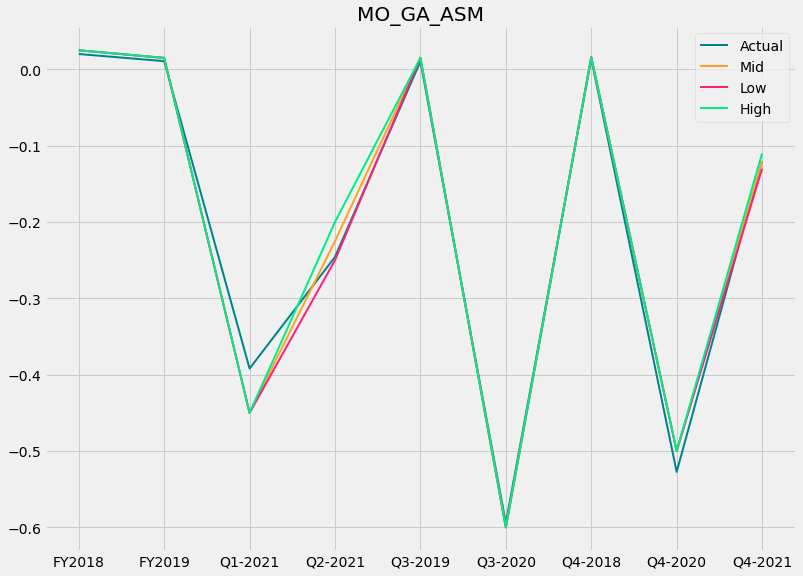

In [30]:
guidance_name = model_set.guidance(ticker).iloc[0]['Item Name']
model_set.plot_guidance(ticker,guidance_name)

We can also look at the full time series from the model, including Canalyst estimates

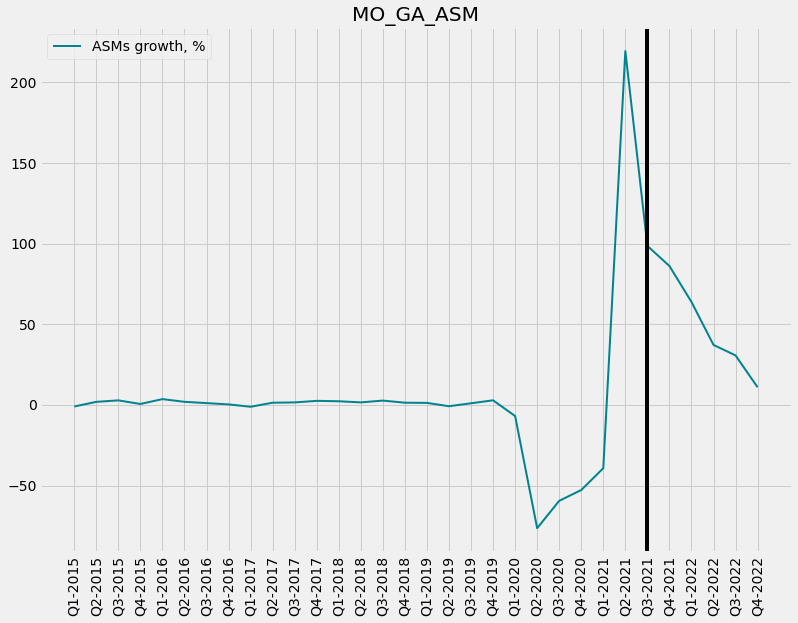

In [31]:
model_set.create_time_series_chart(ticker,guidance_name)

And we can look at the forward estimates for this stock

In [32]:
cdr.get_revenue_estimates(yahoo_ticker)

,Revenue Estimate,Current Qtr. (Dec 2021),Next Qtr. (Mar 2022),Current Year (2021),Next Year (2022)
0,No. of Analysts,11,4,16,16
1,Avg. Estimate,9.09B,9.57B,29.48B,43.49B
2,Low Estimate,9.04B,9.07B,28.5B,39.78B
3,High Estimate,9.31B,9.96B,29.68B,46.7B
4,Year Ago Sales,4.03B,4.04B,17.34B,29.48B
5,Sales Growth (year/est),125.80%,136.80%,70.10%,47.50%
